# Step 2: Perform coarse rigid registration

In [2]:
import neuroglancer
from phathom import plotting
import zarr
import os
import matplotlib.pyplot as plt
import numpy as np
from phathom.registration import coarse
from phathom.utils import pickle_save
import tifffile

In [14]:
viewer = neuroglancer.Viewer()
viewer

http://127.0.0.1:38659/v/6b62beb485206dc3bb8a6b715870db9576f2a39d/

Use this in IPython to allow external viewing (from VM)
```
neuroglancer.set_server_bind_address(bind_address='192.168.158.128', bind_port=80)
```

In [4]:
working_dir = '/home/jswaney/org_registration'

In [16]:
fixed_path = 'round1/syto16.zarr/32_32_32'
moving_path = 'round2/syto16.zarr/32_32_32'
fixed_voxel_size = (1, 1, 2)
moving_voxel_size = (1, 1, 2)
downsample_factor = 32

fixed_store = zarr.NestedDirectoryStore(os.path.join(working_dir, 
                                                     fixed_path))
moving_store = zarr.NestedDirectoryStore(os.path.join(working_dir,
                                                      moving_path))

fixed_down = zarr.load(fixed_store)
moving_down = zarr.load(moving_store)

print('Downsampled shapes:', fixed_down.shape, moving_down.shape)

plotting.plot_both(fixed_down, 
                   moving_down, 
                   viewer, 
                   normalization=3000,
                   fixed_voxel_size=tuple(x*downsample_factor for x in fixed_voxel_size),
                   moving_voxel_size=tuple(x*downsample_factor for x in fixed_voxel_size))

Downsampled shapes: (19, 74, 89) (19, 73, 75)


# Set a threshold for tissue foreground

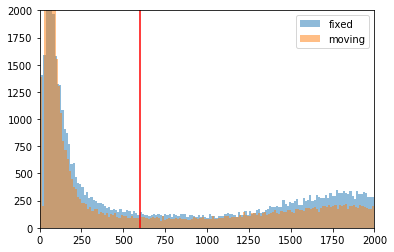

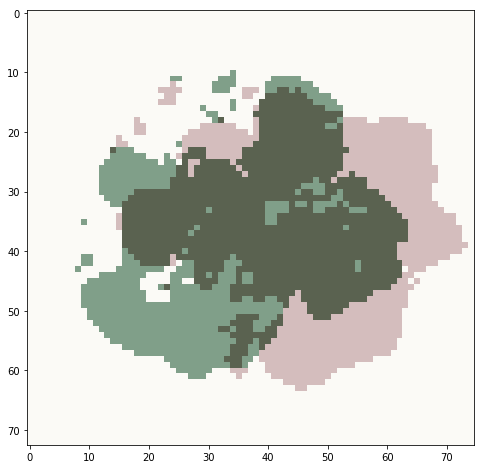

In [6]:
threshold = 600

bins = 256
xmax = 2e3
ymax = 2000

plt.hist(fixed_down.ravel(), bins, alpha=0.5, label='fixed')
plt.hist(moving_down.ravel(), bins, alpha=0.5, label='moving')
plt.plot([threshold, threshold], [0, ymax], 'r-')
plt.xlim([0, xmax])
plt.ylim([0, ymax])
plt.legend()
plt.show()

fixed_mask = (fixed_down > threshold)
moving_mask = (moving_down > threshold)

plt.figure(figsize=(12, 8))
plt.imshow(fixed_mask[fixed_mask.shape[0] // 2], alpha=0.5, cmap='Reds')
plt.imshow(moving_mask[moving_mask.shape[0] // 2], alpha=0.5, cmap='Greens')
plt.legend()
plt.show()

In [8]:
optim_kwargs = {'niter': 10,
                't0': np.zeros(3),
                'theta0': np.array([np.pi/2, 0, np.pi]),
                's0': 1}
min_size = 5
use_hull = False

t_down, theta, center_down, s = coarse.coarse_registration(moving_down, 
                                                        fixed_down, 
                                                        threshold,
                                                        optim_kwargs,
                                                        min_size=min_size,
                                                        use_hull=use_hull)

basinhopping step 0: f 0.233178
basinhopping step 1: f 0.230772 trial_f 0.230772 accepted 1  lowest_f 0.230772
found new global minimum on step 1 with function value 0.230772
basinhopping step 2: f 0.230372 trial_f 0.230372 accepted 1  lowest_f 0.230372
found new global minimum on step 2 with function value 0.230372
basinhopping step 3: f 0.231287 trial_f 0.231287 accepted 1  lowest_f 0.230372
basinhopping step 4: f 0.233079 trial_f 0.233079 accepted 1  lowest_f 0.230372
adaptive stepsize: acceptance rate 0.800000 target 0.500000 new stepsize 0.111111 old stepsize 0.1
basinhopping step 5: f 0.234239 trial_f 0.234239 accepted 1  lowest_f 0.230372
basinhopping step 6: f 0.235968 trial_f 0.235968 accepted 1  lowest_f 0.230372
basinhopping step 7: f 0.232528 trial_f 0.232528 accepted 1  lowest_f 0.230372
basinhopping step 8: f 0.232557 trial_f 0.232557 accepted 1  lowest_f 0.230372
basinhopping step 9: f 0.234813 trial_f 0.234813 accepted 1  lowest_f 0.230372
adaptive stepsize: acceptance 

# Warp downsampled image

In [9]:
s

0.91656624238086581

In [10]:
registered_down = coarse.rigid_warp(moving_down, 
                                    t_down, 
                                    theta,
                                    s,
                                    center_down, 
                                    fixed_down.shape)

plotting.plot_both(fixed_down, 
                   registered_down, 
                   viewer, 
                   normalization=3000,
                   fixed_voxel_size=tuple(x*downsample_factor for x in fixed_voxel_size),
                   moving_voxel_size=tuple(x*downsample_factor for x in fixed_voxel_size))

# Convert to fullres transformation

In [11]:
fixed_fullres_path = 'round1/syto16.zarr/1_1_1'
moving_fullres_path = 'round2/syto16.zarr/1_1_1'

fixed_fullres_store = zarr.NestedDirectoryStore(os.path.join(working_dir, 
                                                             fixed_fullres_path))
moving_fullres_store = zarr.NestedDirectoryStore(os.path.join(working_dir,
                                                              moving_fullres_path))
fixed_img = zarr.open(fixed_fullres_store, mode='r')
moving_img = zarr.open(moving_fullres_store, mode='r')

true_factors = np.array(fixed_img.shape) / np.array(fixed_down.shape)
t, center = coarse._scale_rigid_params(t_down, 
                                          center_down,
                                          true_factors)

print('Fullres:', t, center)
print(fixed_img.shape)
print(fixed_down.shape)

Fullres: [  19.36382414  -77.66485791 -263.8800804 ] [  245.18793636  1121.12106598  1064.74718654]
(578, 2362, 2840)
(19, 74, 89)


# Save the fullres transformation

In [12]:
rigid_path = 'rigid_transformation.pkl'

transformation_dict = {'t': t,
                       'theta': theta,
                       'center': center,
                       's': s}

pickle_save(os.path.join(working_dir, rigid_path), transformation_dict)

# Use Nuggt-align for get manual coarse alignment (optional)

If coarse alignment based on a rigid transformation is not adequate, then we can use nuggt to manually provide correspondences for an affine alignment, which contains more degrees of freedom for better coarse alignment. For this, we need to run nuggt-align to get point correspondences--we need 3D tiffs to do this, so we'll save them from our ZarrStack here.

In [5]:
fixed_path = 'round1/syto16.zarr/2_2_2'
moving_path = 'round2/syto16.zarr/2_2_2'
fixed_voxel_size = (1, 1, 2)
moving_voxel_size = (1, 1, 2)
downsample_factor = 2

fixed_store = zarr.NestedDirectoryStore(os.path.join(working_dir, 
                                                     fixed_path))
moving_store = zarr.NestedDirectoryStore(os.path.join(working_dir,
                                                      moving_path))

fixed_down = zarr.load(fixed_store)
moving_down = zarr.load(moving_store)

fixed_down.shape

(289, 1181, 1420)

In [8]:
tifffile.imsave(os.path.join(working_dir, 'round1/syto16_2x.tif'), fixed_down, compress=1)
tifffile.imsave(os.path.join(working_dir, 'round2/syto16_2x.tif'), moving_down, compress=1)

Now we need to run `nuggt-align` with these tiffs to select corresponding points. Save the points file and read it here: